In [ ]:
# !pip uninstall keras
# !pip install keras==2.12.0

In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.8


In [3]:
!pip install scikeras

In [4]:
# Mount Google Drive if your dataset is stored there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import os
import shutil

In [5]:
cd "/content/drive/MyDrive/Colab Notebooks"

/content/drive/MyDrive/Colab Notebooks


Define the paths for the different parts of the dataset we will be using into train and test

In [6]:
train_data_dir = 'images /train'
test_data_dir = 'images /test'

#**Data Preprocessing**

Import the necessary datasets in the form of;

- training
- validation
- and testing

Below, we went on to normalise each pixel to fit within 0-1 range and teh augmented images for creating appropriate training and testing datasets of images after standardadizing the image sizes

In [7]:
img_width, img_height = 224, 224
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

Found 2539 images belonging to 2 classes.


In [9]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generate batches of augmented data for testing
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 14 images belonging to 2 classes.


Here we went on to the get the list of real and fake files in order to create directories for a set of validation images

In [10]:
# Get the list of files in the 'real' and 'fake' subdirectories of the test set
real_test_files = os.listdir(os.path.join(test_data_dir, 'real'))
fake_test_files = os.listdir(os.path.join(test_data_dir, 'fake'))

# Split the test set into test and validation sets for each class
real_test, real_val = train_test_split(real_test_files, test_size=0.5, random_state=42)
fake_test, fake_val = train_test_split(fake_test_files, test_size=0.5, random_state=42)

# Create directories for the validation set
validation_data_dir = 'images /validation'
os.makedirs(os.path.join(validation_data_dir, 'real'), exist_ok=True)
os.makedirs(os.path.join(validation_data_dir, 'fake'), exist_ok=True)

# Move files from the test set to the validation set
for file in real_val:
    shutil.move(os.path.join(test_data_dir, 'real', file), os.path.join(validation_data_dir, 'real', file))

for file in fake_val:
    shutil.move(os.path.join(test_data_dir, 'fake', file), os.path.join(validation_data_dir, 'fake', file))


In [12]:
train_labels = train_generator.classes
train_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

Display Images form the training dataset

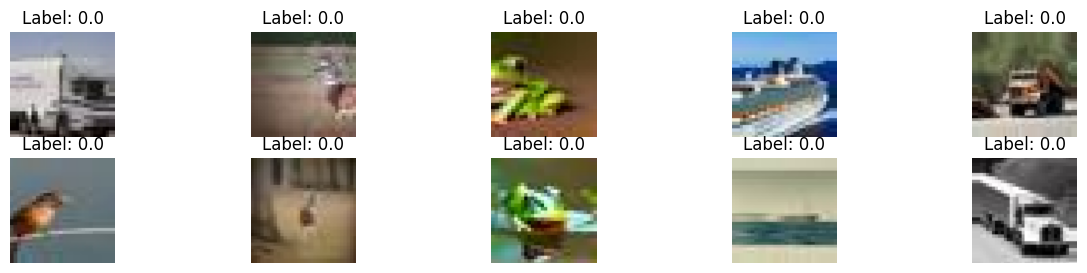

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15,3))

axes = axes.flatten()

for i in range(10):
  batch = train_generator.next()

  images, labels = batch

  axes[i].imshow(images[0])
  axes[i].set_title(f"Label: {labels[0]}")
  axes[i].axis("off")

plt.show()

check the distribution of the images in the training dataset. The distribution here is between.

- Fake
-and Real

In [16]:
all_images, all_labels = [], []
for _ in range (train_generator.samples // train_generator.batch_size):
  batch = train_generator.next()
  all_images.append(batch[0])
  all_labels.append(batch[1])

all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

num_images_class_0 = sum(all_labels == 0)
num_images_class_1 = sum(all_labels == 1)

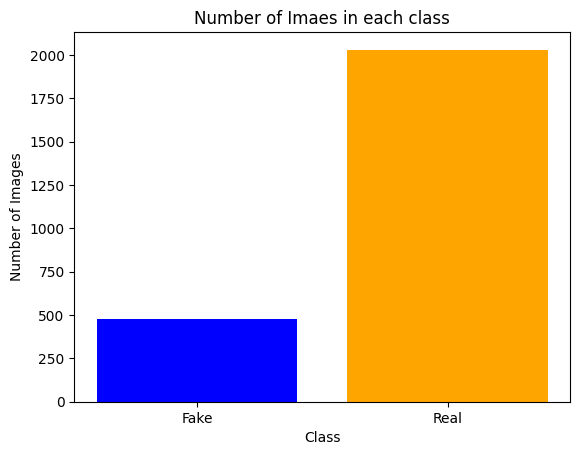

In [17]:
class_labels = ['Fake', 'Real']
num_images = [num_images_class_0, num_images_class_1]

plt.bar(class_labels, num_images, color=['blue', 'orange'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Imaes in each class')
plt.show()

From the destribution graph, it is evident that there are more real images than fake. For this reason, there will be the need for us to cater for this bias later on either

- during traning by changing the weigths
- or during deployment by changing the threshold for classifying an image as fake or real

#**Feature Engineering**

Here, we will use a pretrained image classification model (VGG-16) <br>
to extract necessary features from the dataset which would be used as a bases to train our customised model

In [ ]:
# Load the pre-trained VGG16 model without the final dense layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Extract features from the desired intermediate layer
intermediate_layer_output = base_model.get_layer('block4_pool').output

# Create a new model using the intermediate layer output as input
feature_extraction_model = Model(inputs=base_model.input, outputs=intermediate_layer_output)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:

# Update the test generator to reflect the changes
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Extract labels from the updated test generator
test_labels = test_generator.classes


Found 24 images belonging to 2 classes.


Extract the necessary features from the images in the dataset using the <br>
pre-trained model

In [ ]:
train_features = feature_extraction_model.predict(train_generator)
test_features = feature_extraction_model.predict(test_generator)

Generate validation data from the train generator in order to form a validation generator

In [ ]:
validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Using the pre-trained model, extract features from the validation section of the dataset

In [ ]:
# Extract features and labels for validation set
validation_features = feature_extraction_model.predict(validation_generator)
validation_labels = validation_generator.classes

1/1 [==============================] - 3s 3s/step
Found 776 images belonging to 2 classes.
25/25 [==============================] - 143s 6s/step


In [ ]:
# Rescale the extracted features
train_features /= 255.0
test_features /= 255.0

#Training


Here, we will build our customized sequential model and train it using;

- Gridsearch cross validation
- the features extracted from the training dataset

In [ ]:
# Function to create the model (as a wrapper for Keras model)
def create_model(optimizer='adam', activation='relu', dropout_rate=0.5):
    model = Sequential([
        Flatten(input_shape=train_features.shape[1:]),
        Dense(128, activation=activation),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create a KerasClassifier for use with GridSearchCV
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

Create a parameter grid and kfold for our grid search

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'sgd'],
}

# Use StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
grid_result = grid.fit(train_features, train_labels) #training the model

# Print the best parameters
print("Best Parameters: ", grid_result.best_params_)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Best Parameters:  {'optimizer': 'adam'}


#**Optimization**

Here, based on the parameters specified by the grid search, we will create a new model based on those parameters in order to optimize our model

In [ ]:
print(train_features.shape[1:])

(14, 14, 512)


Define structure of model

In [ ]:
# Function to create the model with the best parameters
def create_model():
    model = Sequential([
        Flatten(input_shape=train_features.shape[1:]),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    # Use the identified 'adam' optimizer
    optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate if needed
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Create model and test it on validation data to check accuracy

In [ ]:
# Create and compile the model
model = create_model()

# Train the model using your training data and validate on the validation set
model.fit(
    train_features, train_labels,
    epochs=30, batch_size=32,
    validation_data=(validation_features, validation_labels)
)

In [ ]:
# Evaluate the model on the validation set
validation_score = model.evaluate(validation_features, validation_labels, verbose=0)

# Print the validation loss and accuracy
print(f'Validation Loss: {validation_score[0]}')
print(f'Validation Accuracy: {validation_score[1]}')

#Save model

In [ ]:

model.save('final.h5')
